In [1]:
import glob, re, h5py
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import convolve1d

In [2]:
def read_Dycore_data(filepath, print_var=True):
    """
    Load Dycore data from HDF5 file.

    Parameters:
        filepath (str): Path to the Dycore HDF5 file.
        print_var (bool): If True, print available variable names.

    Returns:
        tuple: u, v, t, p, ps, w, phi arrays
    """
    with h5py.File(filepath, "r") as f:
        if print_var:
            print("Available variables:", list(f.keys()))

        t   = f["grid_tracers_c_xyzt"][:]      # Temperature
        p   = f["grid_p_full_xyzt"][:]   # 3D pressure

    return t, p

def _extract_day(fp):
    m = re.search(r"_startfrom_(\d+)day", fp)
    return int(m.group(1)) if m else -1

def read_dycore_series(pattern):
    # find & sort
    files = sorted(glob.glob(pattern), key=_extract_day)
    # print(files)

    t_tmp = []; p_tmp = []
    for i, fp in enumerate(files):
        t, p = read_Dycore_data(fp, print_var=(i==0))
        t_tmp.append(t); p_tmp.append(p)

    t_all   = np.concatenate(t_tmp,  axis=0)
    p_all   = np.concatenate(p_tmp,  axis=0)
    return t_all, p_all

In [13]:
def fft2( data ):
    
    data_fft = np.fft.fft( data, axis=0 )
    data_fft = np.fft.ifft( data_fft, axis=-1 ) * data.shape[-1]
    
    # return data_fft.sum( axis=1 )
    return data_fft

def ifft2( data ):
    
    data_ifft = np.fft.ifft( data, axis=0 )
    data_ifft = np.fft.fft( data_ifft, axis=-1 ) / data.shape[-1]
    
    return data_ifft.real

In [4]:
pattern_sst = "/data92/Quark/ctrl_2000d/HSt42_20/RH80_PR20_2000day_startfrom_*_final.dat"
t, p = read_dycore_series(pattern_sst)

Available variables: ['_types', 'convection_xyzt', 'factor1_xyzt', 'factor2_xyzt', 'factor3_xyzt', 'factor4_xyzt', 'grid_div_xyzt', 'grid_geopots_xyzt', 'grid_p_full_xyzt', 'grid_p_half_xyzt', 'grid_ps_c_xyzt', 'grid_ps_p_xyzt', 'grid_t_c_xyzt', 'grid_t_n_xyzt', 'grid_t_p_xyzt', 'grid_tracers_c_xyzt', 'grid_tracers_diff_xyzt', 'grid_tracers_n_xyzt', 'grid_tracers_p_xyzt', 'grid_u_c_xyzt', 'grid_u_n_xyzt', 'grid_u_p_xyzt', 'grid_v_c_xyzt', 'grid_v_n_xyzt', 'grid_v_p_xyzt', 'grid_vor_xyzt', 'grid_w_full_xyzt', 'grid_z_full_xyzt', 'grid_δtracers_xyzt', 'grid_δu_xyzt', 'grid_δv_xyzt', 'spe_div_c_xyzt', 'spe_div_p_xyzt', 'spe_lnps_c_xyzt', 'spe_lnps_p_xyzt', 'spe_t_c_xyzt', 'spe_t_p_xyzt', 'spe_tracers_c_xyzt', 'spe_tracers_p_xyzt', 'spe_vor_c_xyzt', 'spe_vor_p_xyzt']


In [36]:
# lat, lon, and lat_lim
x = np.linspace(0, 360, 128, endpoint=False)
y = np.linspace(-90, 90, 64)
lat_lim = np.where( ( y >= -15.0 ) & ( y <= 15.0 ) )[0]

# temperature data (1000d~2000d)
data = t[4000:8000, 2, lat_lim, :]
# data = t[3000:, 16, lat_lim, :]
print(data.shape)

(4000, 10, 128)


In [6]:
wn = np.fft.fftfreq(128, d=1/128)
fr = np.fft.fftfreq(data.shape[0], d=1/4)

wnm, frm = np.meshgrid( wn, fr )

mask = (
    # ((wnm>=-7)&(wnm<=-3)&(frm>=0.01)&(frm<=0.20)) |
    ((wnm>= 5)&(wnm<= 7)&(frm>=0.01)&(frm<=0.20)) |
    ((wnm>= 11)&(wnm<=14)&(frm>=0.01)&(frm<=0.20)) |
    # ((wnm>=-7)&(wnm<=-3)&(frm<=-0.01)&(frm>=-0.20)) 
    ((wnm>= 5)&(wnm<= 7)&(frm<=-0.01)&(frm>=-0.20)) |
    ((wnm>= 11)&(wnm<=14)&(frm<=-0.01)&(frm>=-0.20)) 
    
)

In [37]:
data -= data.mean( axis=(0, 2), keepdims=True )
# print(data.shape)

kel_reconstruct_xy = []


for i in range(len(lat_lim)):

    sym = ( data[:, i, :] + np.flip( data[:, i, :], axis=1 ) ) / 2
    # print(sym.shape)

    sym_fft = fft2(sym)
    # print(sym_fft.shape)
    sym_fft_masked = sym_fft * mask
    kel_reconstruct_tmp = ifft2( sym_fft_masked )
    kel_reconstruct_xy.append(kel_reconstruct_tmp)

kel_reconstruct_xy = np.array(kel_reconstruct_xy)
kel_reconstruct_xy.shape

(10, 4000, 128)

Text(0.5, 1.0, 'Reconstructed signal @ 100 hPa (Day: 1000.0)')

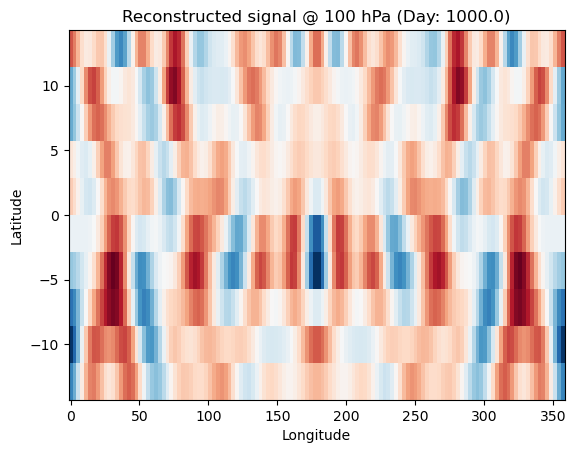

In [38]:
timestep = 0
plt.pcolormesh(x, y[lat_lim], kel_reconstruct_xy[:, timestep, :], cmap="RdBu")
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(f'Reconstructed signal @ 100 hPa (Day: {(timestep + 4000)/4})')